In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

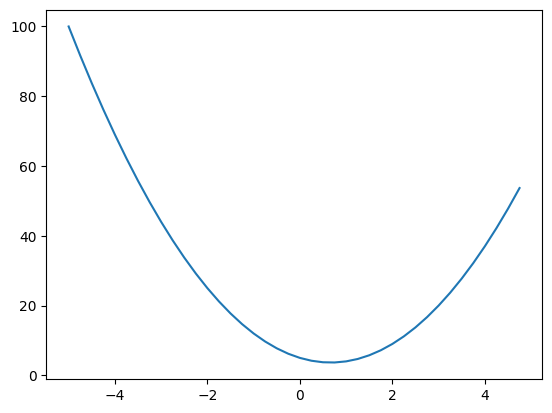

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

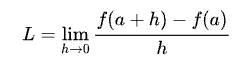

In [8]:
def get_slope(x, h):
    return (f(x + h) - f(x))/h

In [14]:
print(f'slope at min: {get_slope(2/3, 0.000000001):.2f}')
print(f'slope at 3:   {get_slope(3, 0.000001):.2f}')
print(f'slope at -3:  {get_slope(-3, 0.000001):.2f}')

slope at min: 0.00
slope at 3:   14.00
slope at -3:  -22.00


In [15]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [16]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [33]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0  # by default, the gradient is zero, ie: has no effect on the output
    self._backward = lambda: None  # how to perform gradient distribution to children nodes, different for each operation
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # Topological sort to walk through the graph from right to left
    # Depth-first traversal
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # After the topological sort is done, call _backward on each node, in reverse order
    # Ensures that every node the right has completed its gradient distribution first
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

Value(data=-8.0)

In [26]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [133]:
# Initialize the values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

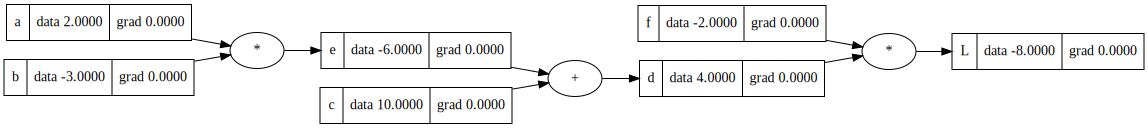

In [134]:
draw_dot(L)

```
L = d * f
dL/dd = ?

By calculus, dL/dd = f
or...
derive it from defn of derivative:
(f(x+h) - f(x)) / h
((d+h)*f - d*f) / h
(d*f + h*f - d*f) / h
h*f / h = f

---

d = c + e
dd/dc = ?

By calculus, dd/dc = 1
or...
derive it from defn of derivative:
(f(x+h) - f(x)) / h
(c+h + e) - (c + e) / h
(c + h + e - c - e) / h
h / h = 1
```

In [135]:
# Do the manual back-prop
L.grad = 1.0  # dL/dL = 1
f.grad = L.grad * d.data  # 1 * 4 = 4
d.grad = L.grad * f.data  # 1 * -2 = -2
c.grad = d.grad * 1.0  # -2
e.grad = d.grad * 1.0 # -2
b.grad = e.grad * a.data  # -2 * 2 = -4
a.grad = e.grad * b.data  # -2 * -3 = 6
print(L.data)

-8.0


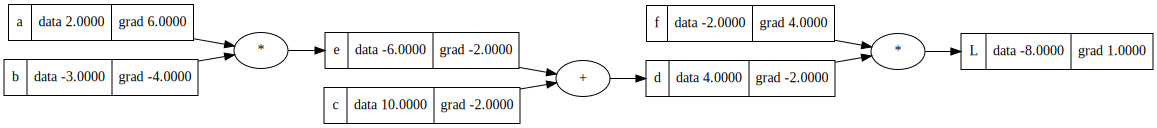

In [136]:
draw_dot(L)

In [131]:
# Adjust the weights by a small step, in the direction of the gradient
step = 0.01
a.data += step * a.grad
b.data += step * b.grad
c.data += step * c.grad
f.data += step * f.grad

# Forward pass
e = a * b
d = e + c
L = d * f

In [132]:
print(L.data)

-7.286496


In [123]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-3.9999999999995595


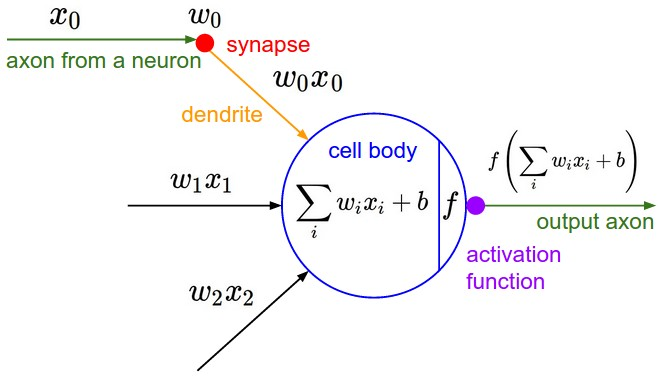

Sigmoid: squashes real numbers to [0, 1]:

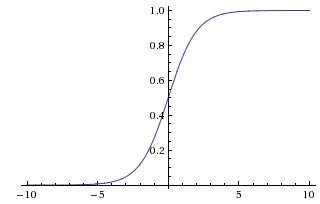

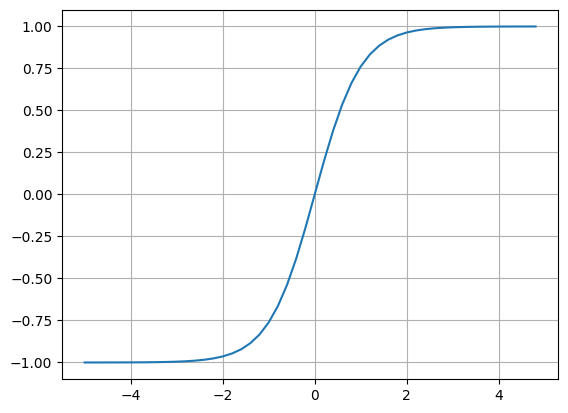

In [137]:
# Tanh squashes real numbers to [-1, 1]
# Both sigmoid and tanh saturate and kill gradients at either tails
# But tanh is preferred since it is zero-centered
# ReLU is better
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [181]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')  # magic number selected to make the math work out
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'  # Cell body raw result, before activation
o = n.tanh(); o.label = 'o'  # output after tanh

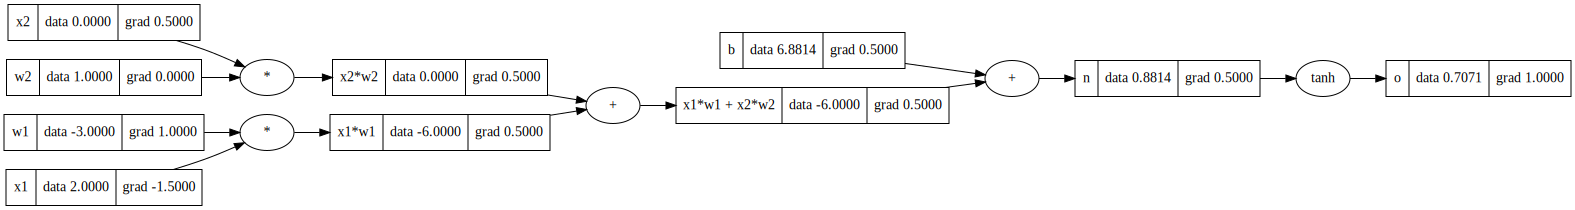

In [183]:
draw_dot(o)

In [147]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Step through each node's `_backwards()` method, one at a time.

In [174]:
o.grad = 1.0  # initialize it for base case

In [175]:
o._backward()

In [176]:
n._backward()

In [177]:
b._backward()

In [178]:
x1w1x2w2._backward()

In [179]:
x2w2._backward()
x1w1._backward()

Or call `backwards()` on the root node to walk all the way through it.

In [182]:
o.grad = 1.0
o.backward()